In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_auc_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from scipy.stats.mstats import gmean
import xgboost as xgb
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
fpath = "/Users/ys8mz/Box Sync/Predictive Models of College Completion (VCCS)/intermediate_files"

In [2]:
df = pd.read_stata(fpath + "/full_data_truncated.dta")
df.loc[:,'available_sum'] = df.loc[:, [p for p in list(df.columns)[10:] if p.startswith("available")]]

In [3]:
train_df_old = df[df.valid == 0]
test_df = df[df.valid == 1]
print(train_df_old.shape,test_df.shape)

(298139, 342) (33115, 342)


##### Randomly select 10% observations from the original training sample

In [4]:
_, train_df = train_test_split(train_df_old, test_size=0.1, stratify=train_df_old['grad_6years'].astype(str)+"_"+train_df_old['available_sum'].astype(str), random_state=54321)

In [6]:
predictors = list(df.columns)[10:-1]
print(len(predictors))
impute_list_1 = set(["prop_comp_pre","cum_gpa_pre"])
impute_list_2 = set([t1+"_"+t2+str(t3) for t1 in ["term_gpa", "prop_comp", "lvl2_prop_comp", "dev_prop_comp"] for t2 in ["fa", "sp", "su"] for t3 in range(1,7,1)])
impute_list_3 = set(["cum_gpa", "lvl2_prop_comp", "dev_prop_comp", "prop_comp", "prop_comp_sd", "withdrawn_prop_comp_sd"])
impute_list_4 = set(["admrate", "gradrate", "satvr25", "satvr75", "satmt25", "satmt75", "satwr25", "satwr75"])

331


In [7]:
def impute(train, test):
    for p in impute_list_1:
        avg_p = np.nanmean(train[train.enrolled_pre == 1][p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    for p in impute_list_3:
        avg_p = np.nanmean(train[p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    for p in impute_list_2:
        suffix = p[-3:]
        avg_p = np.nanmean(train[train["enrolled_" + suffix] == 1][p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    for p in impute_list_4:
        avg_p = np.nanmean(train[train["enrolled_nsc"] == 1][p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    return train, test 

In [8]:
train_df_new, test_df_new = impute(train_df, test_df)
X_train = train_df_new.loc[:,predictors]
y_train = train_df_new.grad_6years
X_test = test_df_new.loc[:,predictors]
y_test = test_df_new.grad_6years

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [9]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [19]:
np.random.seed(4321)
val_indices = np.random.choice(train_df.shape[0], int(np.floor(train_df.shape[0]*0.15)), replace=False)
train_val = train_df.iloc[val_indices,:]
train_train = train_df.iloc[np.setdiff1d(np.arange(train_df.shape[0]), val_indices),:]
train_train_new, train_val_new = impute(train_train, train_val)
X_train_train = train_train_new.loc[:,predictors]
y_train_train = train_train_new.grad_6years
X_train_val = train_val_new.loc[:,predictors]
y_train_val = train_val_new.grad_6years

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [20]:
dtrain_train = xgb.DMatrix(X_train_train, y_train_train)
dtrain_val = xgb.DMatrix(X_train_val, y_train_val)

In [10]:
results_dir = "C:\\Users\\ys8mz\\Box Sync\\Predictive Models of College Completion (VCCS)\\evaluation_results\\smaller_training_sample\\test1\\"

#### (1) Grid Search for max_depth and eta (learning rate)

In [22]:
grid_1 = [(md,e) for md in range(4,8) for e in [0.01, 0.02, 0.05, 0.1, 0.2]]
validation_auc_1 = Counter()
for md,e in grid_1:
    print("max_depth = {0}, eta = {1}:".format(md,e))
    params = {'max_depth': md, 'eta': e, 'min_child_weight': 1, 'colsample_bytree': 0.8, 
              'subsample': 0.8, 
              'objective': 'binary:logistic', 'eval_metric': ['auc'],
              'seed': 12345}
    evals_result = {}
    xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                          early_stopping_rounds = 10,
                          evals_result = evals_result,
                          verbose_eval = 50)
    validation_auc_1[(md,e)] = np.max(evals_result['validation']['auc'])
    print("")

max_depth = 4, eta = 0.01:
[0]	validation-auc:0.81787
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.849962
[100]	validation-auc:0.856933
[150]	validation-auc:0.861182
[200]	validation-auc:0.864424
[250]	validation-auc:0.866941
[300]	validation-auc:0.868861
[350]	validation-auc:0.870855
[400]	validation-auc:0.872123
[450]	validation-auc:0.873405
[500]	validation-auc:0.874295
[550]	validation-auc:0.875088
[600]	validation-auc:0.875809
[650]	validation-auc:0.876272
[700]	validation-auc:0.876683
[750]	validation-auc:0.877178
[800]	validation-auc:0.877584
[850]	validation-auc:0.877896
[900]	validation-auc:0.878225
Stopping. Best iteration:
[927]	validation-auc:0.878336


max_depth = 4, eta = 0.02:
[0]	validation-auc:0.81787
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.856907
[100]	validation-auc:0.864647
[150]	validation-auc:0.869534
[200]	validation-auc:0.872763
[250]	validation-auc:0.874878
[300]	validation-auc:0

In [23]:
for t in validation_auc_1.most_common():
    print(t)

((7, 0.02), 0.880746)
((6, 0.02), 0.880031)
((7, 0.01), 0.880021)
((7, 0.05), 0.879951)
((5, 0.2), 0.87995)
((6, 0.05), 0.879851)
((4, 0.05), 0.879767)
((5, 0.05), 0.879682)
((6, 0.01), 0.879579)
((5, 0.02), 0.879495)
((5, 0.1), 0.879273)
((7, 0.1), 0.879239)
((6, 0.2), 0.878748)
((5, 0.01), 0.878637)
((4, 0.02), 0.878634)
((4, 0.1), 0.878564)
((4, 0.01), 0.878336)
((6, 0.1), 0.878234)
((7, 0.2), 0.878207)
((4, 0.2), 0.876995)


#### (2) Grid Search for min_child_weight (along with max_depth)

In [24]:
md1 = 6
grid_2 = [(md1+i,mcw) for i in [-1,0,1] for mcw in [3,5]]
validation_auc_2 = Counter()
for md,mcw in grid_2:
    print("max_depth = {0}, min_child_weight = {1}:".format(md,mcw))
    params = {'max_depth': md, 'eta': 0.02, 'min_child_weight': mcw, 'colsample_bytree': 0.8, 
              'subsample': 0.8, 
              'objective': 'binary:logistic', 'eval_metric': ['auc'],
              'seed': 12345}
    evals_result = {}
    xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                          early_stopping_rounds = 10,
                          evals_result = evals_result,
                          verbose_eval = 50)
    validation_auc_2[(md,mcw)] = np.max(evals_result['validation']['auc'])
    print("")

max_depth = 5, min_child_weight = 3:
[0]	validation-auc:0.828999
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.862651
[100]	validation-auc:0.869088
[150]	validation-auc:0.873059
[200]	validation-auc:0.875394
[250]	validation-auc:0.877198
[300]	validation-auc:0.878428
[350]	validation-auc:0.87901
[400]	validation-auc:0.879647
Stopping. Best iteration:
[435]	validation-auc:0.879971


max_depth = 5, min_child_weight = 5:
[0]	validation-auc:0.828637
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.862621
[100]	validation-auc:0.86919
[150]	validation-auc:0.872938
[200]	validation-auc:0.875351
[250]	validation-auc:0.877244
[300]	validation-auc:0.878556
[350]	validation-auc:0.879293
[400]	validation-auc:0.879762
[450]	validation-auc:0.880146
Stopping. Best iteration:
[440]	validation-auc:0.88015


max_depth = 6, min_child_weight = 3:
[0]	validation-auc:0.833558
Will train until validation-auc hasn't improved in 10 rounds

In [25]:
for t in validation_auc_2.most_common():
    print(t)

((6, 3), 0.880338)
((5, 5), 0.88015)
((7, 3), 0.880141)
((6, 5), 0.880141)
((5, 3), 0.879971)
((7, 5), 0.879895)


#### (3) Grid Search for colsample_by_tree

In [26]:
grid_3 = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
validation_auc_3 = Counter()
for cbt in grid_3:
    print("colsample_by_tree = {}:".format(cbt))
    params = {'max_depth': 6, 'eta': 0.02, 'min_child_weight': 3, 'colsample_bytree': cbt, 
              'subsample': 0.8, 
              'objective': 'binary:logistic', 'eval_metric': ['auc'],
              'seed': 12345}
    evals_result = {}
    xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                          early_stopping_rounds = 10,
                          evals_result = evals_result,
                          verbose_eval = 50)
    validation_auc_3[cbt] = np.max(evals_result['validation']['auc'])
    print("")

colsample_by_tree = 0.5:
[0]	validation-auc:0.802908
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.868296
[100]	validation-auc:0.872642
[150]	validation-auc:0.875815
[200]	validation-auc:0.877613
[250]	validation-auc:0.879144
[300]	validation-auc:0.880176
[350]	validation-auc:0.880953
[400]	validation-auc:0.881457
[450]	validation-auc:0.881763
Stopping. Best iteration:
[463]	validation-auc:0.881816


colsample_by_tree = 0.55:
[0]	validation-auc:0.802908
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.868478
[100]	validation-auc:0.872616
[150]	validation-auc:0.875183
[200]	validation-auc:0.877036
[250]	validation-auc:0.878576
[300]	validation-auc:0.879651
[350]	validation-auc:0.88025
Stopping. Best iteration:
[352]	validation-auc:0.880261


colsample_by_tree = 0.6:
[0]	validation-auc:0.802657
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.86811
[100]	validation-auc:0.872427
[15

In [27]:
validation_auc_3.most_common()

[(0.5, 0.881816),
 (0.9, 0.880908),
 (0.6, 0.880866),
 (0.8, 0.880338),
 (0.55, 0.880261),
 (0.85, 0.879967),
 (0.65, 0.879912),
 (0.7, 0.879793),
 (0.75, 0.879534)]

#### (4) Finally select the opitmal num_boost_round

In [28]:
params = {'max_depth': 6, 'eta': 0.02, 'min_child_weight': 3, 'colsample_bytree': 0.8, 
          'subsample': 0.8, 
          'objective': 'binary:logistic', 'eval_metric': ['auc'],
          'seed': 12345}
evals_result = {}
xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                      early_stopping_rounds = 10,
                      evals_result = evals_result,
                      verbose_eval = 50)
optimal_num_boost_round = np.argmax(evals_result['validation']['auc'])
print("")
print(optimal_num_boost_round)

[0]	validation-auc:0.833558
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.867397
[100]	validation-auc:0.872158
[150]	validation-auc:0.874928
[200]	validation-auc:0.876968
[250]	validation-auc:0.878358
[300]	validation-auc:0.879407
[350]	validation-auc:0.879895
[400]	validation-auc:0.880315
Stopping. Best iteration:
[404]	validation-auc:0.880338


404


#### (5) Train the final xgb model and make predictions for observations in the test set

In [29]:
# specify parameters via map
params = {'max_depth': 6, 'eta': 0.02, 'min_child_weight': 3, 'colsample_bytree': 0.8, 
          'subsample': 0.8, 
          'objective': 'binary:logistic', 'eval_metric': ['auc'],
          'seed': 12345}
final_xgb_model = xgb.train(params = params, dtrain = dtrain, num_boost_round = optimal_num_boost_round)
# make prediction for observations in the test set
y_test_pred = final_xgb_model.predict(dtest)

In [30]:
print("XGBoost:")
print("AUC = {}".format(round(roc_auc_score(dtest.get_label(), y_test_pred), 4)))

XGBoost:
AUC = 0.8916


In [31]:
# save the model object and predicted scores on the validation sample to local disk
# pickle.dump(final_xgb_model, open(results_dir + "xgb.p", "wb"))
pickle.dump(list(y_test_pred), open(results_dir + "y_test_pred_xgb.p", "wb"))

In [32]:
feature_importance = pd.DataFrame(list(final_xgb_model.get_fscore().items()), columns=['feature','importance']).sort_values('importance', ascending=False)
feature_importance.loc[:, 'importance'] = feature_importance.loc[:, 'importance'] / sum(feature_importance.loc[:, 'importance'])
yy = feature_importance.loc[:, 'importance'].iloc[:20]
xx = feature_importance.loc[:, 'feature'].iloc[:20]

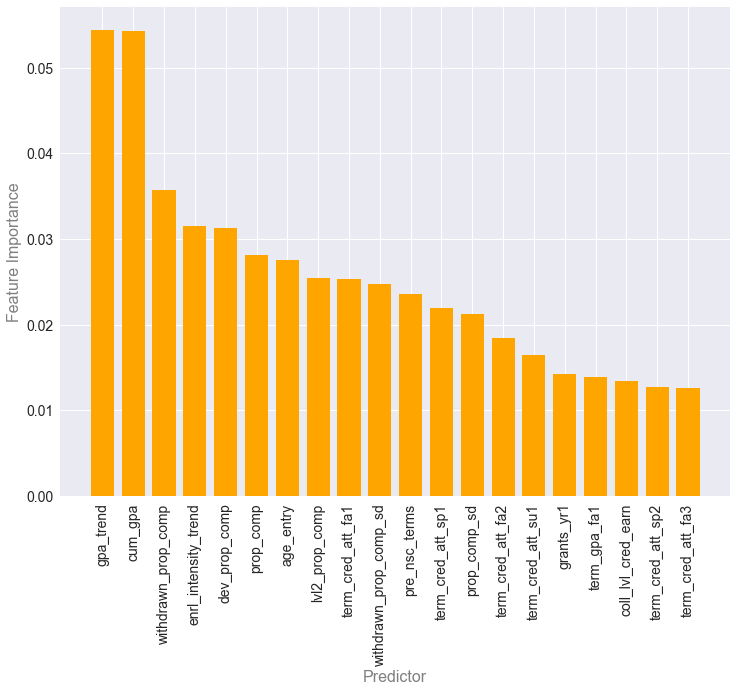

In [34]:
fig = plt.figure(figsize=(12,9))
plt.bar(list(range(20)), yy, width=0.75, color = "orange")
plt.xticks(list(range(20)), xx, rotation = 'vertical', fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Predictor", fontsize=16, color="gray")
plt.ylabel("Feature Importance", fontsize=16, color="gray")
plt.savefig(results_dir + "XGBoost_variable_importance.png", bbox_inches='tight')
plt.show()

In [35]:
def find_optimal_threshold(p,r,t):
    to_drop = np.union1d(np.where(pd.isnull(p[:-1]) == True)[0], np.where(pd.isnull(r[:-1]) == True)[0])
    to_drop = np.union1d(to_drop, np.where(pd.isnull(t) == True)[0])
    to_keep = np.setdiff1d(np.array(list(range(len(p)-1))), to_drop)
    p,r,t = p[to_keep],r[to_keep],t[to_keep]
    f1 = 2*p*r/(p+r)
    best_t = t[np.argmax(f1)]
    best_t
    return best_t

def cross_validation(train, xgb_params, nbr):
    threshold_list = []
    auc_list = []
    k_fold =  StratifiedKFold(n_splits = 10, random_state = 12345, shuffle=True)
    for train_indices, test_indices in k_fold.split(train, train.grad_6years):
        train_part = train.iloc[train_indices,:]
        test_part = train.iloc[test_indices,:]
        train_part_new, test_part_new = impute(train_part, test_part)
        X_1 = train_part_new.loc[:,predictors]
        y_1 = train_part_new.grad_6years
        X_2 = test_part_new.loc[:,predictors]
        y_2 = test_part_new.grad_6years
        dtrain_cv = xgb.DMatrix(X_1,y_1)
        dtest_cv = xgb.DMatrix(X_2,y_2)
        xgb_cv_model = xgb.train(params=xgb_params, dtrain=dtrain_cv, num_boost_round = nbr)
        y_2_pred = xgb_cv_model.predict(dtest_cv)
        p,r,t = precision_recall_curve(y_2, y_2_pred)
        auc = roc_auc_score(y_2, y_2_pred)
        threshold_list.append(find_optimal_threshold(p,r,t))
        auc_list.append(auc)
    print(np.mean(auc_list), np.std(auc_list, ddof=1))
    return gmean(threshold_list)

In [36]:
final_params = {'max_depth': 6, 'eta': 0.02, 'min_child_weight': 3, 'colsample_bytree': 0.8, 
                'subsample': 0.8, 
                'objective': 'binary:logistic', 'eval_metric': ['auc'],
                'seed': 12345}
best_threshold = cross_validation(train_df, final_params, optimal_num_boost_round)

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

0.8844302174300612 0.005288669074033276


In [37]:
best_threshold

0.35812652

In [38]:
def create_confusion_matrix(y_test_pred, threshold, fname):
    cm_arr = confusion_matrix(y_test, np.where(y_test_pred > threshold, 1, 0))
    cm_df = pd.DataFrame(cm_arr, columns=['Pred_0','Pred_1'], index=['Real_0', 'Real_1'])
    cm_df.loc[:,''] = cm_df.sum(axis=1)
    cm_df.loc['',:] = cm_df.sum(axis=0)
    print(cm_df)
    print("")
    p1 = cm_df.iloc[1,1]/cm_df.iloc[2,1]
    r1 = cm_df.iloc[1,1]/cm_df.iloc[1,2]
    p0 = cm_df.iloc[0,0]/cm_df.iloc[2,0]
    r0 = cm_df.iloc[0,0]/cm_df.iloc[0,2]    
    print("F1 score = {}".format(round(2*p1*r1/(p1+r1),4)))    
    cm_df.to_csv(results_dir + fname + ".csv")
    return p1,r1,p0,r0,round(2*p1*r1/(p1+r1),4)

In [39]:
print("F1 threshold = {}:\n".format(str(round(best_threshold,3))))
pr_xgb = create_confusion_matrix(y_test_pred, best_threshold, "XGBoost_cm1")

F1 threshold = 0.358:

         Pred_0   Pred_1         
Real_0  18210.0   3598.0  21808.0
Real_1   2268.0   9039.0  11307.0
        20478.0  12637.0  33115.0

F1 score = 0.755


In [40]:
num_of_0 = int(round((1-np.mean(train_df.grad_6years))*len(y_test)))
y_test_pred_binary = np.ones(len(y_test))
y_test_pred_binary[np.argsort(y_test_pred)[:num_of_0]] = 0
alternative_threshold = y_test_pred[np.argsort(y_test_pred)[num_of_0]]
print("Alternative threshold = {}:\n".format(str(round(alternative_threshold,3))))
pr2_xgb = create_confusion_matrix(y_test_pred_binary, best_threshold, "XGBoost_cm2")

Alternative threshold = 0.429:

         Pred_0   Pred_1         
Real_0  18968.0   2840.0  21808.0
Real_1   2821.0   8486.0  11307.0
        21789.0  11326.0  33115.0

F1 score = 0.7499


In [41]:
precision_recall_df = pd.DataFrame([(best_threshold,)+pr_xgb,(alternative_threshold,)+pr2_xgb]).round(4)
precision_recall_df.index = ['F1','Same_Graduation_Rate']
precision_recall_df.columns = ['threshold','precision_1','recall_1','precision_0','recall_0','f1_score']
precision_recall_df.to_csv(results_dir + "XGBoost_precision_recall.csv", index=True)

#### Comparison with reduced validation

##### Randomly select 10% observations from the original validation sample

In [12]:
results_dir_new1 = "C:\\Users\\ys8mz\\Box Sync\\Predictive Models of College Completion (VCCS)\\evaluation_results\\smaller_training_sample\\test1\\comparison_1\\"

In [13]:
test_df_old = df[df.valid == 1]
_, test_df_reduced = train_test_split(test_df_old, test_size=0.1, stratify=test_df_old['grad_6years'].astype(str)+"_"+test_df_old['available_sum'].astype(str), random_state=54321)

In [14]:
_, test_df_reduced_new = impute(train_df, test_df_reduced)
X_test_reduced = test_df_reduced_new.loc[:,predictors]
y_test_reduced = test_df_reduced_new.grad_6years
dtest_reduced = xgb.DMatrix(X_test_reduced, y_test_reduced)

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [16]:
print("XGBoost:")
y_test_reduced_pred = xgboost.predict(dtest_reduced)
print("AUC = {}".format(round(roc_auc_score(dtest_reduced.get_label(), xgboost.predict(dtest_reduced)), 4)))

XGBoost:
AUC = 0.8942


In [18]:
pickle.dump(list(y_test_reduced_pred), open(results_dir_new1 + "y_test_pred_xgb.p", "wb"))

In [48]:
def create_confusion_matrix_new(y_test, y_test_pred, threshold, fpath, fname):
    cm_arr = confusion_matrix(y_test, np.where(np.array(y_test_pred) > threshold, 1, 0))
    cm_df = pd.DataFrame(cm_arr, columns=['Pred_0','Pred_1'], index=['Real_0', 'Real_1'])
    cm_df.loc[:,''] = cm_df.sum(axis=1)
    cm_df.loc['',:] = cm_df.sum(axis=0)
    print(cm_df)
    print("")
    p1 = cm_df.iloc[1,1]/cm_df.iloc[2,1]
    r1 = cm_df.iloc[1,1]/cm_df.iloc[1,2]
    p0 = cm_df.iloc[0,0]/cm_df.iloc[2,0]
    r0 = cm_df.iloc[0,0]/cm_df.iloc[0,2]    
    print("F1 score = {}".format(round(2*p1*r1/(p1+r1),4)))    
    cm_df.to_csv(fpath + fname + ".csv")
    return p1,r1,p0,r0,round(2*p1*r1/(p1+r1),4)

In [49]:
def create_pr(train_df, y_test, y_test_pred, best_threshold, fpath, mn):
    print("F1 threshold = {}:\n".format(str(round(best_threshold,3))))
    pr_lr = create_confusion_matrix_new(y_test, y_test_pred, best_threshold, fpath, "{}_cm1".format(mn))

    num_of_0 = int(round((1-np.mean(train_df.grad_6years))*len(y_test)))
    y_test_pred_binary = np.ones(len(y_test))
    y_test_pred_binary[np.argsort(y_test_pred)[:num_of_0]] = 0
    alternative_threshold = y_test_pred[np.argsort(y_test_pred)[num_of_0]]
    print("\n\n")
    print("Alternative threshold = {}:\n".format(str(round(alternative_threshold,3))))
    pr2_lr = create_confusion_matrix_new(y_test, y_test_pred_binary, best_threshold, fpath, "{}_cm2".format(mn))

    precision_recall_df = pd.DataFrame([(best_threshold,)+pr_lr,(alternative_threshold,)+pr2_lr]).round(4)
    precision_recall_df.index = ['F1','Same_Graduation_Rate']
    precision_recall_df.columns = ['threshold','precision_1','recall_1','precision_0','recall_0','f1_score']
    precision_recall_df.to_csv(fpath + "{}_precision_recall.csv".format(mn), index=True)

In [50]:
create_pr(train_df, y_test_reduced, y_test_reduced_pred, best_threshold, results_dir_new1, "XGBoost")

F1 threshold = 0.358:

        Pred_0  Pred_1        
Real_0  1848.0   333.0  2181.0
Real_1   218.0   913.0  1131.0
        2066.0  1246.0  3312.0

F1 score = 0.7682



Alternative threshold = 0.423:

        Pred_0  Pred_1        
Real_0  1913.0   268.0  2181.0
Real_1   266.0   865.0  1131.0
        2179.0  1133.0  3312.0

F1 score = 0.7641


#### Comparison with the base model (trained on the full training data), using the reduced validation sample

In [19]:
results_dir_new2 = "C:\\Users\\ys8mz\\Box Sync\\Predictive Models of College Completion (VCCS)\\evaluation_results\\smaller_training_sample\\test1\\comparison_2\\"

In [20]:
model_dir = "C:\\Users\\ys8mz\\Box Sync\\Predictive Models of College Completion (VCCS)\\evaluation_results\\truncated_predictors\\"
base_xgboost = pickle.load(open(model_dir + "xgb.p", "rb"))

In [21]:
train_df_old = df[df.valid == 0]
test_df_old = df[df.valid == 1]
_, test_df_reduced = train_test_split(test_df_old, test_size=0.1, stratify=test_df_old['grad_6years'].astype(str)+"_"+test_df_old['available_sum'].astype(str), random_state=54321)

In [22]:
test_df_reduced.shape

(3312, 342)

In [23]:
_, test_df_reduced_new = impute(train_df_old, test_df_reduced)
X_test_reduced = test_df_reduced_new.loc[:,predictors]
y_test_reduced = test_df_reduced_new.grad_6years

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [24]:
dtest_reduced = xgb.DMatrix(X_test_reduced, y_test_reduced)

In [25]:
print("XGBoost:")
y_test_reduced_pred = base_xgboost.predict(dtest_reduced)
print("AUC = {}".format(round(roc_auc_score(dtest_reduced.get_label(), base_xgboost.predict(dtest_reduced)), 4)))

XGBoost:
AUC = 0.9096


In [26]:
pickle.dump(list(y_test_reduced_pred), open(results_dir_new2 + "y_test_pred_xgb.p", "wb"))

In [57]:
create_pr(train_df_old, y_test_reduced, y_test_reduced_pred,  0.38526425, results_dir_new2, "XGBoost")

F1 threshold = 0.385:

        Pred_0  Pred_1        
Real_0  1906.0   275.0  2181.0
Real_1   212.0   919.0  1131.0
        2118.0  1194.0  3312.0

F1 score = 0.7905



Alternative threshold = 0.444:

        Pred_0  Pred_1        
Real_0  1937.0   244.0  2181.0
Real_1   242.0   889.0  1131.0
        2179.0  1133.0  3312.0

F1 score = 0.7853


#### Reorganize files of key evaluation metrics for the five models fitted on the random 10% training sample: OLS, Logit, RF, XGBoost, CoxPH

In [1]:
results_dir_new1 = "C:\\Users\\ys8mz\\Box Sync\\Predictive Models of College Completion (VCCS)\\evaluation_results\\smaller_training_sample\\test1\\comparison_1\\"
results_dir_new2 = "C:\\Users\\ys8mz\\Box Sync\\Predictive Models of College Completion (VCCS)\\evaluation_results\\smaller_training_sample\\test1\\comparison_2\\"

In [6]:
# Key evaluation metrics used to generate Appendix Figure A24 of the paper
cstat = [0.8805, 0.8762, 0.8778, 0.8916] + [0.8815, 0.8773, 0.8768, 0.8942] + [0.8861, 0.8807, 0.8884, 0.9096]
m_dict = {'Logit': 'LR1', 'OLS': 'OLS',
          'RF': 'RF', 'XGBoost': 'XGBoost'}
m_list = ['Logit', 'OLS', 'RF', 'XGBoost']
summary = []
for c,m in zip(cstat[:4],m_list):
    summary.append((m,"10%","full",c)+tuple(pd.read_csv(results_dir + "\\{}_precision_recall.csv".format(m_dict[m])).iloc[0,1:]))
for c,m in zip(cstat[4:8],m_list):
    summary.append((m,"10%","10%",c)+tuple(pd.read_csv(results_dir_new1 + "\\{}_precision_recall.csv".format(m_dict[m])).iloc[0,1:]))
for c,m in zip(cstat[8:],m_list):
    summary.append((m,"full","10%",c)+tuple(pd.read_csv(results_dir_new2 + "\\{}_precision_recall.csv".format(m_dict[m])).iloc[0,1:]))
summary_df = pd.DataFrame(summary, columns=['model', 'training_sample', 'validation_sample',
                                            'c-statistic','threshold','precision_1','recall_1',
                                            'precision_0','recall_0','f1_score_1'])
summary_df.loc[:,'f1_score_0'] = 2*summary_df.precision_0*summary_df.recall_0/(summary_df.precision_0+summary_df.recall_0)
summary_df.to_csv(results_dir + "cleaned_results\\main_eval_metrics.csv", index=False)